In [1]:
import pandas as pd

data = pd.read_csv('C:\\Users\\alessandra.flaccaven\\rnn\\train.csv')
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [2]:
# Checking for missing values
data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [3]:
#out of 20k training samples, 39 samples (bothering only the text column) have missing values. 
#out of 20k training samples, 1957 samples (bothering only the author column) have missing values. 
#out of 20k training samples, 558 samples (bothering only the title column) have missing values. 

# here I am choosing which information to use for the classification: title column

# I'll fill the other values with a placeholder string and drop the null titles

data[['text','author']] = data[['text','author']].fillna(value = 'Missing')
data =  data.dropna()
data.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [4]:
# defining the length attribute for the title column

length = []
[length.append(len(str(title))) for title in data['title']]
data['length'] = length
data.head()

,id,title,author,text,label,length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,81
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,55
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,33
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,63
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,93


In [5]:
detail = data['length'].describe()
print(detail)

count    20242.000000
mean        74.319336
std         23.161910
min          3.000000
25%         60.000000
50%         75.000000
75%         88.000000
max        456.000000
Name: length, dtype: float64


In [6]:
# the minimum length is 3: this may represent outliers, let's take a look at it/them

len(data[data['length']<10])

17

In [7]:
# let's take a look at those ouliers

data['title'][data['length']<10]

86          Poison
1977     Tweetwave
2561          Wow!
2881     6.1 Italy
5697      Trumped!
7423       俄罗斯总统观注
10596    Rick Rule
11624    What If….
12617     Untitled
15728          Rum
16049    What Now?
17081         EPIC
17607    Candidate
17927    Wikileaks
19428     Ooh Fuck
19741    RIP, Vine
20523        White
Name: title, dtype: object

In [8]:
# I could either drop such articles, or keep them. I may try both possibilities

# keep

X=data['title']
y=data['label']
X.shape
y.shape

(20242,)

In [9]:
#importing all necessary modules that I will be using to build the LSTM neural network

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [10]:
# As I dropped some rows with null values I'll reset the indexes to make them uniform

X=X.reset_index()
X=X.drop(['index'],axis=1)
X.tail()

,title
20237,Rapper T.I.: Trump a ’Poster Child For White S...
20238,"N.F.L. Playoffs: Schedule, Matchups and Odds -..."
20239,Macy’s Is Said to Receive Takeover Approach by...
20240,"NATO, Russia To Hold Parallel Exercises In Bal..."
20241,What Keeps the F-35 Alive


In [11]:
y=y.reset_index()
y=y.drop(['index'],axis=1)
y.tail()

,label
20237,0
20238,0
20239,0
20240,1
20241,1


In [12]:
# importing nltk, stopwords and porterstemmer 
# I am tokenizing the title text

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [13]:
ps = PorterStemmer()
corpus = []

# Each row of the dataset is taken into account 

for i in range(0, len(X)):
    review = re.sub('[^a-zA-Z]', ' ',X['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [14]:
corpus[30]

'chuck todd buzzfe eic publish fake news breitbart'

In [15]:
# vocabulary size

voc_size=5000

In [16]:
# performing one hot representation

onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [17]:
# specifying the sentence length so that every sentence in the corpus will be of the same length, using padding when needed 

sent_length=25
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 4539 2664 3706]
 [   0    0    0 ... 2794 3575 2352]
 [   0    0    0 ...  325  505 3389]
 ...
 [   0    0    0 ... 2379  570 4861]
 [   0    0    0 ... 2124 2418 4228]
 [   0    0    0 ... 1179 2408 1245]]


In [18]:
import numpy as np

X_final=np.array(embedded_docs)
y_final=np.array(y)
X_final.shape,y_final.shape

((20242, 25), (20242, 1))

In [19]:
# splitting data for training and testing 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)

In [20]:
# Creating GRU model

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU

embedding_vector_features=40
gru_model=Sequential()
gru_model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
gru_model.add(Dropout(0.3))
gru_model.add(GRU(200))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(1,activation='sigmoid'))
gru_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

gru_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 25, 40)            0         
_________________________________________________________________
gru (GRU)                    (None, 200)               145200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 345,401
Trainable params: 345,401
Non-trainable params: 0
_________________________________________________________________


In [21]:
train_history = gru_model.fit(x = X_train,
                               y = y_train,
                               validation_data=(X_test,y_test),
                               epochs = 20,
                               batch_size = 64,
                               verbose = 1)


Epoch 1/20
254/254 [==============================] - 12s 45ms/step - loss: 0.2680 - accuracy: 0.8906 - val_loss: 0.1982 - val_accuracy: 0.9148
Epoch 2/20
254/254 [==============================] - 9s 37ms/step - loss: 0.1355 - accuracy: 0.9470 - val_loss: 0.1983 - val_accuracy: 0.9126
Epoch 3/20
254/254 [==============================] - 10s 40ms/step - loss: 0.0977 - accuracy: 0.9649 - val_loss: 0.2186 - val_accuracy: 0.9210
Epoch 4/20
254/254 [==============================] - 10s 38ms/step - loss: 0.0698 - accuracy: 0.9749 - val_loss: 0.2576 - val_accuracy: 0.9195
Epoch 5/20
254/254 [==============================] - 11s 42ms/step - loss: 0.0503 - accuracy: 0.9828 - val_loss: 0.3254 - val_accuracy: 0.9192
Epoch 6/20
254/254 [==============================] - 10s 39ms/step - loss: 0.0373 - accuracy: 0.9874 - val_loss: 0.3065 - val_accuracy: 0.9069
Epoch 7/20
254/254 [==============================] - 11s 43ms/step - loss: 0.0395 - accuracy: 0.9860 - val_loss: 0.3543 - val_accuracy: 

In [22]:
import matplotlib.pyplot as plt

%matplotlib inline
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

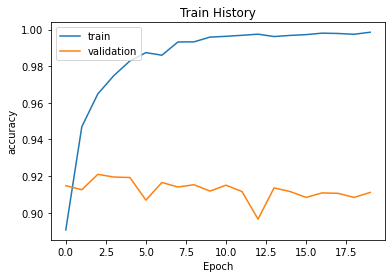

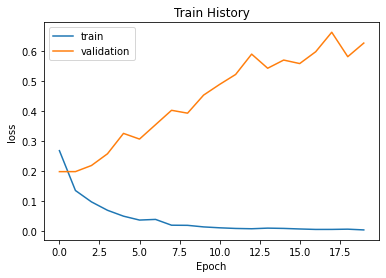

In [23]:
show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

In [24]:
#loading test dataset for prediction

test = pd.read_csv('C:\\Users\\alessandra.flaccaven\\rnn\\test.csv')
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [25]:
#null values in the test dataset

test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [26]:
# I'll fill the other values with a placeholder string and drop the null titles

test[['text','author','title']] = test[['text','author','title']].fillna(value = 'Missing')
test.isnull().sum()

id        0
title     0
author    0
text      0
dtype: int64

In [27]:
test.shape

(5200, 4)

In [28]:
#creating corpus for the test dataset exactly the same as for the training dataset

corpus_test = []
for i in range(0, len(test)):
    review = re.sub('[^a-zA-Z]', ' ',test['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_test.append(review)

In [29]:
#creating one hot representation for the test corpus

onehot_repr_test=[one_hot(words,voc_size)for words in corpus_test] 

In [30]:
#padding for the test dataset
sent_length=25

embedded_docs_test=pad_sequences(onehot_repr_test,padding='pre',maxlen=sent_length)
print(embedded_docs_test)

[[   0    0    0 ... 2379  570 4861]
 [   0    0    0 ... 3751  345  455]
 [   0    0    0 ... 3477 4322 1271]
 ...
 [   0    0    0 ... 2379  570 4861]
 [   0    0    0 ...   74 2240 3570]
 [   0    0    0 ... 2379  570 4861]]


In [31]:
X_test=np.array(embedded_docs_test)

In [33]:
#making predictions for the test dataset

check=gru_model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [34]:
check

array([[0],
       [1],
       [1],
       ...,
       [0],
       [1],
       [0]])

In [35]:
check.shape

(5200, 1)

In [36]:
# dropping the other columns so the prediction and the test set have the same shape

test=test.drop(['text','id','author'],axis=1)
test.head()

,title
0,"Specter of Trump Loosens Tongues, if Not Purse..."
1,Russian warships ready to strike terrorists ne...
2,#NoDAPL: Native American Leaders Vow to Stay A...
3,"Tim Tebow Will Attempt Another Comeback, This ..."
4,Keiser Report: Meme Wars (E995)


In [37]:
val=[]
for i in check:
    val.append(i[0])

In [38]:
output = pd.read_csv('C:\\Users\\alessandra.flaccaven\\rnn\\expected.csv')
output.head()

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1


In [39]:
# inserting the predictions in the csv file

output['label']=val

In [40]:
output.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [41]:
#saving the output file

output.to_csv('C:\\Users\\alessandra.flaccaven\\rnn\\output_gru_rnn.csv',index=False)